In [ ]:
import tensorflow as tf

tf.__version__

## DNN (Deep Neural Network) 으로 텍스트 분류하기


## 라이브러리 로드

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

In [3]:
# tensorflow
# TextVectorization, Embedding, GlobalAveragePooling1D
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.layers import GlobalAvgPool1D, Dense, Dropout

## 데이터 미리보기 및 요약

In [4]:
# 학습, 예측 데이터셋을 불러옵니다.
# pecab 으로 조사, 구두점을 제거한 데이터를 불러옵니다. 
# 전처리 되지 않은 텍스트를 사용해도 상관 없습니다.
train = pd.read_csv("data/klue/train_pecab.csv")
test = pd.read_csv("data/klue/test_pecab.csv")
train.shape, test.shape

((45654, 4), (9131, 3))

In [5]:
# value_counts()로 분류별 빈도수 확인합니다.
train["topic_idx"].value_counts(1)

topic_idx
4    0.167105
2    0.161256
5    0.151860
6    0.147873
1    0.136286
3    0.129956
0    0.105664
Name: proportion, dtype: float64

In [6]:
# 정답(label) 값을 설정합니다.
label_name = "topic_idx"
label_name

'topic_idx'

## label one-hot 형태로 만들기

In [7]:
# from keras.utils import to_categorical
from keras.utils import to_categorical
# get_dummies 를 사용하여 label 값을 one-hot 형태로 만듭니다.
y = to_categorical(train[label_name])
y.shape

(45654, 7)

In [8]:
# value_counts 로 정답 빈도 보기
train[label_name].value_counts().sort_index()

topic_idx
0    4824
1    6222
2    7362
3    5933
4    7629
5    6933
6    6751
Name: count, dtype: int64

In [9]:
# train[label_name]

In [10]:
# one-hot-encoding 정답 빈도 보기
pd.DataFrame(y).sum()

0    4824.0
1    6222.0
2    7362.0
3    5933.0
4    7629.0
5    6933.0
6    6751.0
dtype: float32

## 검증용 데이터 만들기와 데이터 누수

* 아래의 경우 데이터 누수(Data Leakage)에 해당됩니다.
* label encoding, one-hot encoding 시 test 데이터 셋 활용하여 encoder를 fit하는 경우
* data scaling 적용 시 test 데이터 셋 활용하여 scaler를 fit하는 경우
* pandas의 get_dummies() 함수를 test 데이터셋에 적용하는 경우
* test 데이터 셋의 결측치 처리 시 test 데이터 셋의 통계 값 활용
* test 데이터 셋을 EDA하여 얻은 인사이트를 통해 학습에 활용하는 경우
* test 데이터 셋을 학습 과정에 사용하는 모든 행위 (test 데이터셋은 추론에만 활용되어야 합니다)
* test 데이터 셋의 데이터 개수 정보를 활용하는 경우 (실제 test 데이터셋은 몇개가 입력으로 들어올 지 모르기 때문)
* 위 예시 외에도 test 데이터 셋이 모델 학습에 활용되는 경우에 Data leakage에 해당됨.
* 출처 : https://dacon.io/competitions/official/236055/talkboard/407731 


In [11]:
X = train["title"]
X_test_text = test["title"]

In [12]:
# train_test_split
from sklearn.model_selection import train_test_split

X_train_text, X_valid_text, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train_text.shape, X_valid_text.shape, y_train.shape, y_valid.shape

((36523,), (9131,), (36523, 7), (9131, 7))

In [13]:
# 층화표집이 잘 되었는지 확인
pd.DataFrame(y_train).mean()

0    0.105659
1    0.136298
2    0.161268
3    0.129946
4    0.167100
5    0.151850
6    0.147879
dtype: float32

In [14]:
pd.DataFrame(y_valid).mean()

0    0.105684
1    0.136239
2    0.161209
3    0.129997
4    0.167123
5    0.151900
6    0.147848
dtype: float32

## TextVectorization

* 매개변수
    * max_tokens: 텍스트에서 고려할 최대 토큰 수를 지정합니다. 가장 빈도가 높은 max_tokens 개의 토큰만 사용됩니다.
    * standardize: 텍스트를 표준화하는 방법을 선택합니다. 'lower_and_strip_punctuation'로 설정하면 소문자로 변환하고 문장부호를 제거합니다.
    * split: 텍스트를 토큰화하는 방법을 선택합니다. 'whitespace'로 설정하면 공백을 기준으로 텍스트가 토큰화됩니다.
    * ngrams: 단일 토큰 이상의 n-그램을 생성하도록 지정합니다. 예를 들어, ngrams=2로 설정하면 바이그램이 생성됩니다.
    * output_mode: 출력 모드를 지정합니다. 'int'로 설정하면 정수로 변환된 토큰이 출력됩니다.
    * output_sequence_length: 출력 시퀀스의 길이를 지정합니다. 이 매개변수를 사용하여 모든 시퀀스를 고정된 길이로 패딩하거나 자를 수 있습니다.
    * pad_to_max_tokens: True로 설정하면 max_tokens으로 시퀀스를 패딩합니다.
    * vocabulary: 사용할 어휘 사전을 지정합니다. 사전이 제공되면 모델은 이 사전에 있는 토큰만 고려합니다.
    * sparse: True로 설정하면 희소 텐서를 출력합니다.
    * ragged: True로 설정하면 불규칙한 길이의 토큰을 나타내는 tf.RaggedTensor를 출력합니다.
    * encoding: 텍스트의 인코딩을 지정합니다.
    * kwargs: 기타 설정을 위한 추가적인 키워드 인수를 받습니다.


* API Document: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [15]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
# 소문자 변환: 입력된 텍스트를 모두 소문자로 변경합니다.
# HTML 태그 제거: HTML 태그(<br />)를 공백으로 대체합니다.
# 구두점 제거: 모든 구두점을 제거합니다.

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')

## MAX_SEQUENCE_LENGTH 
* 단어 수에 대한 빈도 수 고려하기

In [17]:
# 단어 빈도수의 기술 통계 구하기
train["title"].map(lambda x: len(x.split())).describe()

count    45654.000000
mean         6.588207
std          1.474083
min          1.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: title, dtype: float64

In [18]:
# TextVectorization 레이어 설정
# standardize, max_tokens, output_mode
vocab_size = 10000
MAX_SEQUENCE_LENGTH = 10

vectorizer = TextVectorization(standardize=custom_standardization, 
                               max_tokens=vocab_size, 
                               output_sequence_length=MAX_SEQUENCE_LENGTH)
# X_train_text 만 넣어주면 valid 에 있는 어휘는 학습이 되지 않습니다.
# test 에만 있는 어휘는 데이터 누수 문제로 사용하지 않습니다.
vectorizer.adapt(X)

In [19]:
X.shape

(45654,)

In [20]:
X_train = vectorizer(X_train_text)
X_train

<tf.Tensor: shape=(36523, 10), dtype=int64, numpy=
array([[   4,    1, 1391, ...,    0,    0,    0],
       [ 531,  102,    1, ...,  437,    0,    0],
       [2457, 7737,    1, ...,    0,    0,    0],
       ...,
       [   1,    1,   81, ...,    0,    0,    0],
       [ 105, 2300,   84, ...,    0,    0,    0],
       [ 898, 9971,    1, ...,  554,    0,    0]])>

In [21]:
X_valid = vectorizer(X_valid_text)
X_valid

<tf.Tensor: shape=(9131, 10), dtype=int64, numpy=
array([[  23, 1924,  569, ...,    0,    0,    0],
       [   1,    1,    1, ...,    0,    0,    0],
       [ 130,   65,    1, ...,    0,    0,    0],
       ...,
       [   1,  171,  615, ..., 3147,    0,    0],
       [   1,    1, 1930, ...,    0,    0,    0],
       [3609, 1861, 5525, ...,    0,    0,    0]])>

In [22]:
X_test = vectorizer(X_test_text)
X_test

<tf.Tensor: shape=(9131, 10), dtype=int64, numpy=
array([[1179,   88,    1, ...,    0,    0,    0],
       [   1, 3462,    1, ...,    0,    0,    0],
       [1731,    1,  940, ...,    0,    0,    0],
       ...,
       [3265,   19,    1, ...,  278,   36,    0],
       [   4, 5895,    1, ...,    0,    0,    0],
       [1503, 8864,    1, ...,    0,    0,    0]])>

In [23]:
vocab = vectorizer.get_vocabulary()
len(vocab), vocab[:10]

(10000, ['', '[UNK]', '첫', '등', '게시판', '北', '신간', '대통령', '감독', '美'])

### 텍스트 길이 시각화

<Axes: >

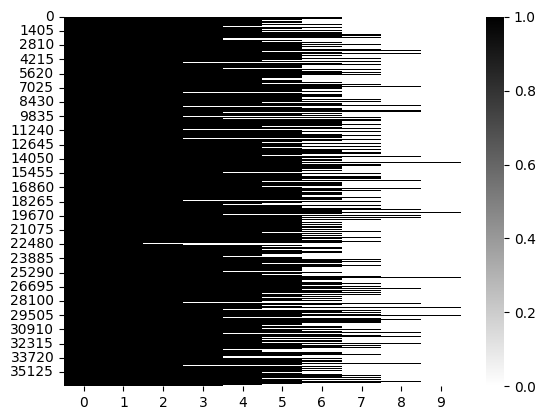

In [24]:
df_train = pd.DataFrame(X_train)
sns.heatmap(df_train.replace(0, np.nan).notnull(), cmap="gray_r")

###  vocab index 분포
* 0에 가까울 수록 빈도수가 높음

<Axes: >

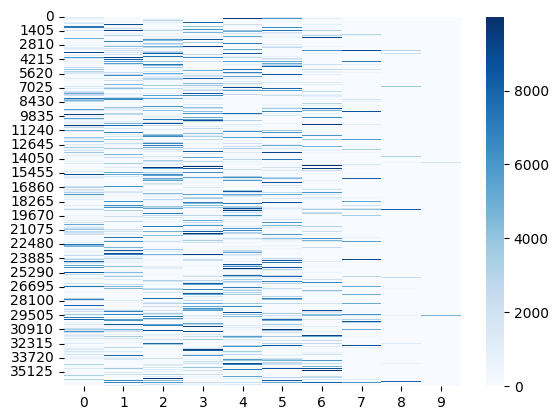

In [25]:
# vocab index 분포 : 0에 가까울 수록 빈도수가 높음

sns.heatmap(df_train, cmap="Blues")

## 임베딩 

* https://www.tensorflow.org/text/guide/word_embeddings?hl=ko
* https://damien0x0023.github.io/rnnExplainer/

In [26]:
# 하이퍼파라미터(모델링할 때 사용자가 직접 세팅해주는 값)을 설정합니다.
# vocab_size는 텍스트 데이터의 전체 단어 집합의 크기입니다.
# embedding_dim는 임베딩 할 벡터의 차원입니다.
# max_length는 패딩의 기준이 됩니다.

embedding_dim = 64

In [27]:
X_train.shape, embedding_dim

(TensorShape([36523, 10]), 64)

In [28]:
embedding_layer = Embedding(input_dim=vocab_size, 
                            output_dim=embedding_dim, 
                            input_length=MAX_SEQUENCE_LENGTH)
embedding_train = embedding_layer(X_train)
embedding_train.shape

TensorShape([36523, 10, 64])

## GlobalAvgPool1D

* 고정된 출력 크기: GlobalAvgPool1D를 사용하면 입력 텍스트의 길이에 관계없이 고정된 출력 크기를 얻을 수 있습니다. 이는 다양한 길이의 문장을 처리하고 동일한 크기의 임베딩을 얻을 수 있도록 해줍니다.
* 전역 정보 캡처: GlobalAvgPool1D는 각 시퀀스 차원에 대한 평균을 계산합니다. 이로써 각 차원의 전역 정보를 캡처할 수 있습니다. 이는 문장의 중요한 특징을 추출하는 데 도움이 되며, 특히 문장이 길거나 다양한 길이일 때 유용합니다.
* 과적합 방지: GlobalAvgPool1D를 사용하면 모델이 입력의 특정 위치에 과도하게 의존하는 것을 방지할 수 있습니다. 이는 모델을 더욱 일반화되게 만들어주어 새로운 데이터에 대한 성능을 향상시킬 수 있습니다.
* 계산 효율성: GlobalAvgPool1D는 입력의 평균을 계산하므로 모델이 더 적은 파라미터로 텍스트를 처리할 수 있습니다. 이는 모델의 효율성을 높여줍니다.

<Axes: >

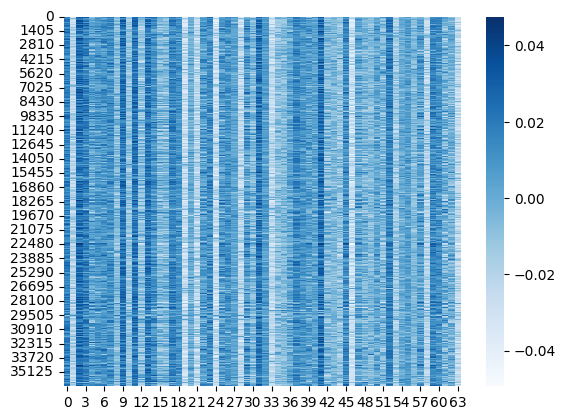

In [29]:
# avg_pooling_layer heatmap
avg_pooling_layer = GlobalAvgPool1D()
sns.heatmap(avg_pooling_layer(embedding_train), cmap="Blues")

## 층 구성
 <img src="https://cs231n.github.io/assets/nn1/neural_net2.jpeg" width="40%">

* 이미지 출처 : https://cs231n.github.io/neural-networks-1/

In [30]:
# 클래스의 수는 분류될 예측값의 종류입니다.
# 정답값이 one-hot 형태로 인코딩 되어 있기 때문에 정답값의 컬럼의 수가 예측값의 종류가 됩니다.
n_class = y.shape[1]
n_class

7

In [31]:
# Sequential Layer

model = Sequential()
model.add(embedding_layer)
model.add(avg_pooling_layer)
model.add(Dense(units=32))
model.add(Dense(units=32))
model.add(Dropout(0.1))
model.add(Dense(units=n_class, activation="softmax"))

## 모델 컴파일

In [32]:
# 여러개 정답 중 하나 맞추는 문제이며, 정답값이 one-hot 형태이기 때문에
# 손실 함수는 categorical_crossentropy를 사용합니다.
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=["accuracy"]
             )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 64)            640000    
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                        

## 학습 fit

<img src="https://i.imgur.com/uWkUCu1.png" width="700">

* https://www.tensorflow.org/tensorboard/get_started?hl=ko

In [33]:
# Clear any logs from previous runs
# !rm -rf ./logs/

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [35]:
# 모델 학습을 실행합니다.
history = model.fit(X_train, y_train, 
                    epochs=100, batch_size=64,
                    callbacks=[early_stop, tensorboard_callback],
                    validation_data=(X_valid, y_valid), 
                    use_multiprocessing=True)

Epoch 1/100
571/571 [==============================] - 5s 7ms/step - loss: 1.9155 - accuracy: 0.2338 - val_loss: 1.8588 - val_accuracy: 0.3242
Epoch 2/100
571/571 [==============================] - 4s 6ms/step - loss: 1.6878 - accuracy: 0.4186 - val_loss: 1.4772 - val_accuracy: 0.4944
Epoch 3/100
571/571 [==============================] - 4s 7ms/step - loss: 1.2654 - accuracy: 0.5718 - val_loss: 1.1239 - val_accuracy: 0.6478
Epoch 4/100
571/571 [==============================] - 5s 8ms/step - loss: 0.9647 - accuracy: 0.7131 - val_loss: 0.9166 - val_accuracy: 0.7133
Epoch 5/100
571/571 [==============================] - 5s 9ms/step - loss: 0.7742 - accuracy: 0.7695 - val_loss: 0.8045 - val_accuracy: 0.7419
Epoch 6/100
571/571 [==============================] - 5s 9ms/step - loss: 0.6607 - accuracy: 0.7974 - val_loss: 0.7555 - val_accuracy: 0.7565
Epoch 7/100
571/571 [==============================] - 5s 9ms/step - loss: 0.5922 - accuracy: 0.8158 - val_loss: 0.7335 - val_accuracy: 0.7621

In [36]:
# 모델 학습의 결과값을 데이터 프레임으로 만들어 확인합니다.
df_hist = pd.DataFrame(history.history)
df_hist

,loss,accuracy,val_loss,val_accuracy
0,1.915491,0.233771,1.858788,0.324170
1,1.687816,0.418558,1.477236,0.494360
2,1.265440,0.571831,1.123945,0.647793
3,0.964691,0.713140,0.916577,0.713284
4,0.774205,0.769488,0.804488,0.741868
5,0.660717,0.797415,0.755495,0.756544
6,0.592205,0.815815,0.733546,0.762129
7,0.543883,0.828738,0.727113,0.765305
8,0.507081,0.840046,0.727900,0.767933
9,0.478468,0.847192,0.735628,0.767714


<Axes: >

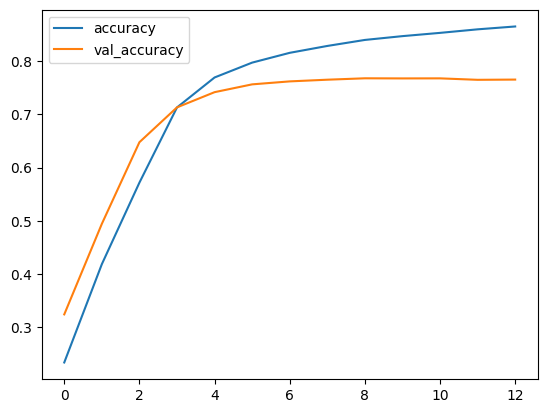

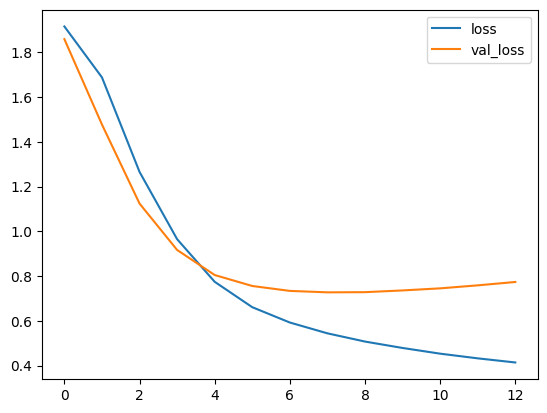

In [37]:
# 모델 학습 결과을 그래프로 시각화합니다.
df_hist[["accuracy", "val_accuracy"]].plot()

df_hist[["loss", "val_loss"]].plot()

## tensorboard

In [38]:
# !kill 12560

In [39]:
# docs_infra: no_execute
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir logs

## 예측

In [40]:
# predict() 메서드로 모델 예측합니다.
y_pred = model.predict(X_test)
y_pred

286/286 [==============================] - 1s 2ms/step


array([[8.0801569e-02, 2.2034501e-03, 8.0298111e-02, ..., 1.4386712e-05,
        4.9931288e-05, 6.4478465e-04],
       [7.2929435e-03, 1.8064224e-05, 5.0704936e-03, ..., 5.2279836e-07,
        2.4451876e-05, 9.5766480e-04],
       [5.4923394e-03, 4.1641062e-01, 3.4390444e-01, ..., 2.2868495e-01,
        1.0138005e-03, 2.4723965e-03],
       ...,
       [3.3167287e-04, 1.7262064e-03, 9.5582205e-01, ..., 6.7922096e-03,
        3.0153947e-06, 1.8400089e-03],
       [3.8869318e-03, 8.4279617e-03, 8.6501324e-01, ..., 4.1686180e-03,
        4.3241605e-05, 5.1592998e-03],
       [5.9307557e-02, 3.8020182e-02, 4.2050555e-01, ..., 6.1491843e-02,
        1.9236408e-02, 1.6983426e-01]], dtype=float32)

In [41]:
X_test.shape

TensorShape([9131, 10])

In [42]:
y_pred.shape

(9131, 7)

In [43]:
y_pred[0].round(3)

array([0.081, 0.002, 0.08 , 0.836, 0.   , 0.   , 0.001], dtype=float32)

In [44]:
np.argmax(y_pred[0].round(3))

3

In [45]:
# numpy.argmax를 이용해 가장 큰 값의 인덱스들을 반환한 값(클래스 예측)을 y_predict에 할당합니다.
y_predict = np.argmax(y_pred, axis=1)
y_predict

array([3, 3, 1, ..., 2, 2, 2])

## 평가
* 실제 미래의 데이터나 경진대회 데이터는 test 의 정답을 모릅니다. 
* 그렇기 때문에 validation 점수를 평가 점수로 활용합니다.

## 제출하기

In [46]:
# sample_submission 파일을 불러옵니다.
# Dacon 에 제출할 답안지 양식입니다.
submit = pd.read_csv("data/klue/sample_submission.csv")
submit.head()

,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0


In [47]:
# 정답값 측정을 위해 y_test 변수에 할당
submit["topic_idx"] = y_predict
submit

,index,topic_idx
0,45654,3
1,45655,3
2,45656,1
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,6
9128,54782,2
9129,54783,2


In [48]:
valid_accuracy = df_hist["val_accuracy"].iloc[-1]
valid_accuracy

0.7655240297317505

In [49]:
file_name = f"data/klue/submit_{valid_accuracy:.5f}.csv"
file_name

'data/klue/submit_0.76552.csv'

In [50]:
# 잘 저장이 되었는지 확인합니다.
submit.to_csv(file_name, index=False)

In [51]:
# 잘 저장이 되었는지 확인합니다.
pd.read_csv(file_name)

,index,topic_idx
0,45654,3
1,45655,3
2,45656,1
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,6
9128,54782,2
9129,54783,2


* dacon에 제출해서 리더보드 확인하기 : https://dacon.io/competitions/official/235747/mysubmission


## 여러 방법을 통해 예측비율을 높여보세요. 
* 아래 항목 외의 기법을 사용해도 됩니다.
 * 전처리 하기
 * 불용어 처리
 * BOW, TF-IDF의 파라메터 변경
 * 분류기의 파라메터 변경
 * 분류기 변경

## 임베딩 프로젝터 사용하기
* 임베딩 프로젝터 : [링크](https://projector.tensorflow.org/?hl=ko&_gl=1*qcvijm*_ga*ODk4NzAxOTgzLjE3MDExNjQyNzM.*_ga_W0YLR4190T*MTcwMTgzNzYzMy42LjEuMTcwMTgzODU2Mi4wLjAuMA..)

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 64)            640000    
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                        

In [55]:
# No such layer: embedding. Existing layers are: ['embedding_2', 등의 메시지가 나온다면
# 컴파일을 여러번 해서 그렇습니다. embedding_2 등으로 변경해 주거나 해당 주피터 노트북의 커널 메뉴에서 재시작을 해주시면 됩니다.
# weights
# vocab
weights = model.get_layer("embedding").get_weights()[0]
vocab[:5]

['', '[UNK]', '첫', '등', '게시판']

In [56]:
# 가장 첫 데이터는 패딩으로 이후 데이터 부터 사용
# 파일로 저장 : "metadata.tsv",  sep="\t", index=False, header=False
df_vocab = pd.DataFrame(vocab[1:])
df_vocab.to_csv("metadata.tsv", sep="\t", index=False, header=False)
pd.read_csv("metadata.tsv", sep="\t")

,[UNK]
0,첫
1,등
2,게시판
3,北
4,신간
...,...
9993,유전
9994,유적지서
9995,유재학
9996,유작


In [60]:
len(vocab)

10000

In [62]:
# "vectors.tsv"
# index=False, header=False 로 저장
df_w = pd.DataFrame(weights[1:len(vocab)])
df_w.to_csv("vectors.tsv", sep="\t", index=False, header=False)
pd.read_csv("vectors.tsv", sep="\t")

,0.028860005,-0.008518149,0.011149544,0.03334895,-0.044875365,-0.0059244833,-0.008393443,0.03598408,0.019184528,0.021563917,...,0.014284497,0.021882534,0.017717712,-0.041302726,-0.032528136,0.015711958,-0.007659546,0.043409344,-0.04697898,-0.019096287
0,0.000079,0.062209,-0.002926,-0.034228,-0.026267,-0.045932,-0.043771,0.038674,0.032519,-0.005231,...,-0.000144,0.005793,0.033466,0.031695,-0.014692,0.005405,-0.050271,0.017555,-0.042483,-0.001198
1,0.026414,0.023652,-0.049181,-0.055469,-0.020713,-0.028795,0.011644,-0.031900,0.036717,0.016442,...,0.044521,0.009129,-0.022808,-0.006571,-0.040317,-0.010388,-0.005443,-0.046363,0.000965,0.003977
2,0.045805,0.022574,-0.008717,-0.060783,-0.040915,0.002459,-0.081793,-0.055452,0.041896,-0.012106,...,0.076406,0.004336,-0.029210,0.049894,0.073312,0.070259,0.000018,-0.047029,-0.043795,0.011769
3,0.124532,-0.205385,-0.024536,0.139517,0.017220,0.018779,-0.033909,0.120246,-0.108034,0.098391,...,-0.018094,-0.060518,-0.295961,0.180571,0.063166,-0.202538,0.088497,-0.061556,0.031086,-0.268413
4,0.279020,0.201306,0.208950,-0.197009,0.014894,0.243593,-0.289949,-0.204406,0.021535,0.287219,...,0.260904,0.229252,0.139135,0.221611,0.175619,-0.165376,-0.151369,-0.256736,-0.291457,-0.270207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,-0.081649,0.000172,-0.089738,0.039247,-0.018184,-0.036058,0.001768,0.026176,-0.044527,-0.005049,...,0.053482,-0.056330,-0.063727,0.010894,-0.060314,-0.011151,0.062533,0.048059,0.082622,0.024229
9994,0.040260,0.022945,0.028558,0.023264,-0.017190,0.015610,-0.013329,-0.009363,-0.016426,0.057796,...,0.047665,-0.023888,0.030551,-0.001755,-0.022116,-0.000100,-0.067137,-0.030007,0.001329,-0.003552
9995,0.013745,-0.012348,-0.040098,-0.027229,-0.017523,-0.003914,0.015030,0.062865,-0.007050,0.061646,...,-0.027338,-0.005591,0.002602,-0.074280,-0.011137,-0.061436,0.008413,0.067636,-0.054809,0.056328
9996,0.058168,0.001182,0.035824,0.003908,-0.060566,0.039207,-0.076985,-0.048396,0.025510,-0.003636,...,0.068256,0.031676,-0.018490,0.074634,0.059604,0.015853,-0.024710,-0.062099,-0.075197,-0.012451


* 임베딩 프로젝터 : [링크](https://projector.tensorflow.org/?hl=ko&_gl=1*qcvijm*_ga*ODk4NzAxOTgzLjE3MDExNjQyNzM.*_ga_W0YLR4190T*MTcwMTgzNzYzMy42LjEuMTcwMTgzODU2Mi4wLjAuMA..)

In [ ]:
# colab 사용시 파일 다운로드
# try:
#     from google.colab import files
#     files.download('vectors.tsv')
#     files.download('metadata.tsv')
# except Exception:
#     pass